# TD Scikit-Learn : Régression et Classification
## Master 2 Banque Finance Assurance - Paris Dauphine

**Durée** : 3 heures

**Objectifs** :
- Maîtriser les concepts d'overfitting, régularisation (Ridge, Lasso)
- Comprendre le processus train/validation/test et cross-validation
- Appréhender le bias-variance tradeoff
- Mesurer la performance des modèles avec les bonnes métriques
- Pratiquer scikit-learn sur des cas concrets

In [1]:
# Imports nécessaires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.datasets import fetch_california_housing, load_breast_cancer
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Configuration des graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

---
# PARTIE 1 : COURS THÉORIQUE (30 min)
---

## 1.1 Overfitting et Régularisation

### Qu'est-ce que l'overfitting ?

L'**overfitting** (surapprentissage) se produit quand un modèle apprend trop bien les données d'entraînement, incluant le bruit et les particularités spécifiques, au détriment de sa capacité de généralisation.

**Signes d'overfitting** :
- Performance excellente sur les données d'entraînement
- Performance médiocre sur les données de test
- Modèle trop complexe (trop de paramètres)

### Ridge vs Lasso : Deux approches de régularisation

La régularisation ajoute une pénalité à la fonction de coût pour contraindre les coefficients du modèle.

#### Ridge Regression (L2)
$$\text{Coût} = \text{MSE} + \alpha \sum_{i=1}^{n} \beta_i^2$$

- Pénalise le **carré** des coefficients
- Réduit les coefficients vers zéro sans les annuler
- Utile quand toutes les variables sont potentiellement pertinentes
- Gère bien la multicolinéarité

#### Lasso Regression (L1)
$$\text{Coût} = \text{MSE} + \alpha \sum_{i=1}^{n} |\beta_i|$$

- Pénalise la **valeur absolue** des coefficients
- Peut mettre certains coefficients exactement à zéro
- Effectue une **sélection de variables**
- Utile quand on pense que peu de variables sont vraiment importantes

**Paramètre α (alpha)** :
- α = 0 : pas de régularisation (régression linéaire standard)
- α petit : peu de régularisation
- α grand : forte régularisation (coefficients plus contraints)

### Illustration : Ridge vs Lasso

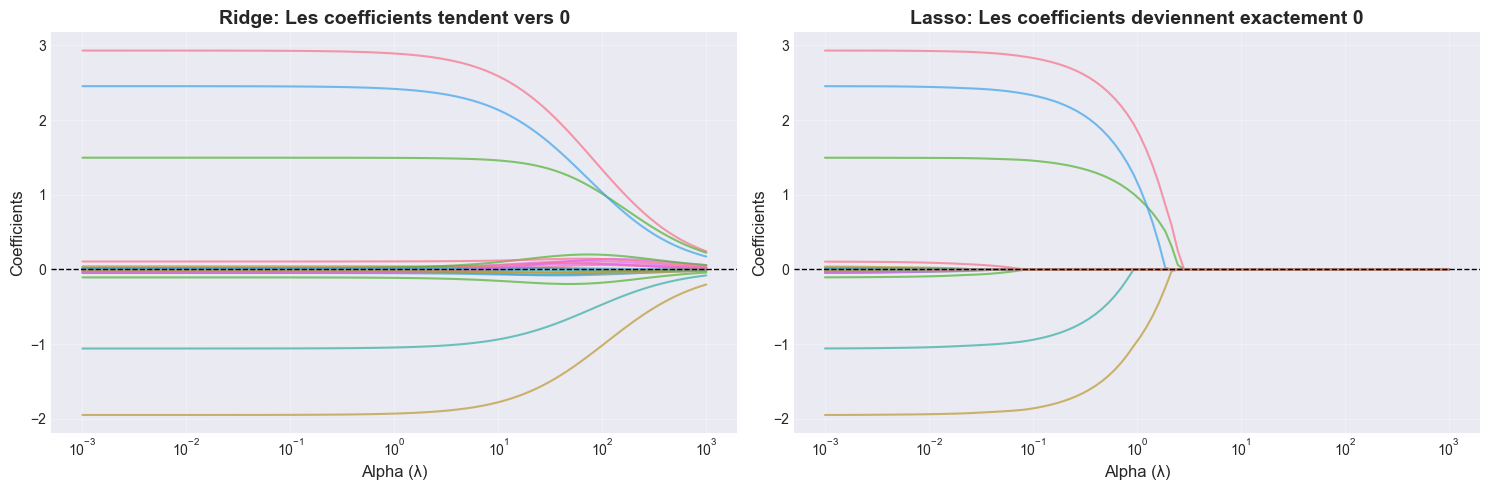

Observation : Ridge réduit progressivement tous les coefficients.
              Lasso met certains coefficients exactement à 0 (sélection de variables).


In [2]:
# Génération de données synthétiques avec des variables corrélées
np.random.seed(42)
n_samples = 100
n_features = 20

# Créer des features corrélées
X = np.random.randn(n_samples, n_features)
# Seulement 5 features sont vraiment importantes
true_coef = np.zeros(n_features)
true_coef[:5] = [3, -2, 1.5, -1, 2.5]
y = X @ true_coef + np.random.randn(n_samples) * 0.5

# Test différentes valeurs de alpha
alphas = np.logspace(-3, 3, 100)
ridge_coefs = []
lasso_coefs = []

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X, y)
    ridge_coefs.append(ridge.coef_)
    
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X, y)
    lasso_coefs.append(lasso.coef_)

ridge_coefs = np.array(ridge_coefs)
lasso_coefs = np.array(lasso_coefs)

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Ridge
for i in range(n_features):
    axes[0].plot(alphas, ridge_coefs[:, i], alpha=0.7)
axes[0].set_xscale('log')
axes[0].set_xlabel('Alpha (λ)', fontsize=12)
axes[0].set_ylabel('Coefficients', fontsize=12)
axes[0].set_title('Ridge: Les coefficients tendent vers 0', fontsize=14, fontweight='bold')
axes[0].axhline(y=0, color='k', linestyle='--', linewidth=1)
axes[0].grid(True, alpha=0.3)

# Lasso
for i in range(n_features):
    axes[1].plot(alphas, lasso_coefs[:, i], alpha=0.7)
axes[1].set_xscale('log')
axes[1].set_xlabel('Alpha (λ)', fontsize=12)
axes[1].set_ylabel('Coefficients', fontsize=12)
axes[1].set_title('Lasso: Les coefficients deviennent exactement 0', fontsize=14, fontweight='bold')
axes[1].axhline(y=0, color='k', linestyle='--', linewidth=1)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Observation : Ridge réduit progressivement tous les coefficients.")
print("              Lasso met certains coefficients exactement à 0 (sélection de variables).")

## 1.2 Train, Validation et Test

### Division des données

1. **Training set (60-80%)** : Entraîner le modèle
2. **Validation set (10-20%)** : Ajuster les hyperparamètres
3. **Test set (10-20%)** : Évaluation finale (ne jamais toucher avant la fin !)

### K-Fold Cross-Validation

La validation croisée divise les données en K parties (folds) :
- Entraîne sur K-1 folds
- Valide sur le fold restant
- Répète K fois en changeant le fold de validation
- Moyenne les résultats

**Avantages** :
- Utilise mieux les données (surtout si dataset petit)
- Donne une estimation plus robuste de la performance
- Détecte mieux l'overfitting

**Valeur typique** : K = 5 ou K = 10

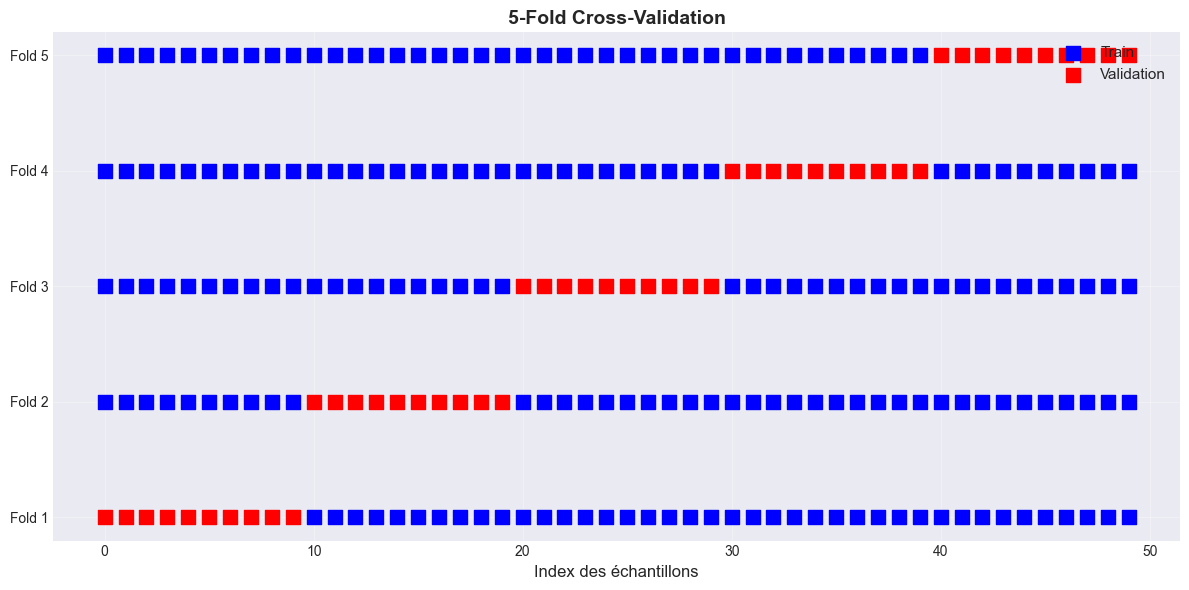

In [3]:
# Illustration de la K-Fold Cross-Validation
fig, ax = plt.subplots(figsize=(12, 6))

n_splits = 5
n_samples = 50

for i in range(n_splits):
    # Train
    train_indices = [j for j in range(n_samples) if j // (n_samples // n_splits) != i]
    ax.scatter(train_indices, [i] * len(train_indices), c='blue', marker='s', s=100, label='Train' if i == 0 else '')
    
    # Validation
    val_indices = [j for j in range(n_samples) if j // (n_samples // n_splits) == i]
    ax.scatter(val_indices, [i] * len(val_indices), c='red', marker='s', s=100, label='Validation' if i == 0 else '')

ax.set_yticks(range(n_splits))
ax.set_yticklabels([f'Fold {i+1}' for i in range(n_splits)])
ax.set_xlabel('Index des échantillons', fontsize=12)
ax.set_title('5-Fold Cross-Validation', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 1.3 Bias-Variance Tradeoff

L'erreur totale d'un modèle se décompose en :

$$\text{Erreur} = \text{Bias}^2 + \text{Variance} + \text{Bruit irréductible}$$

### Bias (Biais)
- Erreur due aux **hypothèses simplificatrices** du modèle
- Modèle trop simple → **Underfitting** → Bias élevé
- Le modèle rate des patterns importants

### Variance
- Sensibilité du modèle aux **fluctuations** des données d'entraînement
- Modèle trop complexe → **Overfitting** → Variance élevée
- Le modèle apprend le bruit

### Le Tradeoff
- Réduire le bias augmente souvent la variance
- Réduire la variance augmente souvent le bias
- **Objectif** : Trouver le bon équilibre

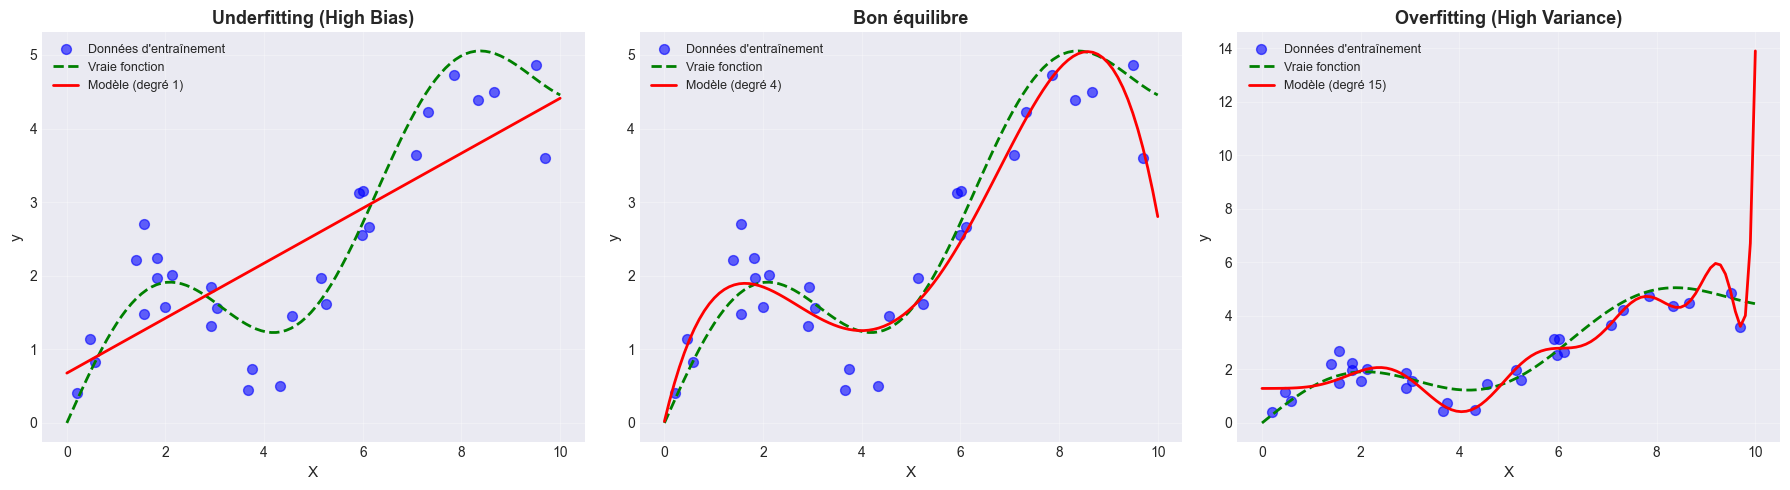

In [4]:
# Illustration du Bias-Variance Tradeoff
np.random.seed(42)

# Fonction vraie
def true_function(x):
    return np.sin(x) + 0.5 * x

# Données
X_true = np.linspace(0, 10, 100).reshape(-1, 1)
y_true = true_function(X_true).ravel()

X_train = np.random.uniform(0, 10, 30).reshape(-1, 1)
y_train = true_function(X_train).ravel() + np.random.normal(0, 0.5, X_train.shape[0])

# Modèles avec différentes complexités
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models = [
    (1, "Underfitting (High Bias)"),
    (4, "Bon équilibre"),
    (15, "Overfitting (High Variance)")
]

for idx, (degree, title) in enumerate(models):
    # Entraînement
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X_train)
    model = LinearRegression()
    model.fit(X_poly, y_train)
    
    # Prédiction
    X_true_poly = poly.transform(X_true)
    y_pred = model.predict(X_true_poly)
    
    # Graphique
    axes[idx].scatter(X_train, y_train, color='blue', s=50, alpha=0.6, label='Données d\'entraînement')
    axes[idx].plot(X_true, y_true, 'g--', linewidth=2, label='Vraie fonction')
    axes[idx].plot(X_true, y_pred, 'r-', linewidth=2, label=f'Modèle (degré {degree})')
    axes[idx].set_xlabel('X', fontsize=11)
    axes[idx].set_ylabel('y', fontsize=11)
    axes[idx].set_title(title, fontsize=13, fontweight='bold')
    axes[idx].legend(fontsize=9)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 1.4 Métriques de Performance

### Pour la Régression

#### R² (Coefficient de détermination)
$$R^2 = 1 - \frac{\sum(y_i - \hat{y}_i)^2}{\sum(y_i - \bar{y})^2}$$
- Varie entre -∞ et 1 (1 = parfait)
- Proportion de variance expliquée

#### R² ajusté
$$R^2_{adj} = 1 - (1-R^2)\frac{n-1}{n-p-1}$$
- Pénalise l'ajout de variables non significatives
- Meilleur pour comparer des modèles avec nombre de variables différent

#### MSE (Mean Squared Error)
$$MSE = \frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2$$
- Pénalise fortement les grandes erreurs
- Sensible aux outliers

#### RMSE (Root Mean Squared Error)
$$RMSE = \sqrt{MSE}$$
- Même unité que la variable cible
- Plus interprétable que MSE

#### MAE (Mean Absolute Error)
$$MAE = \frac{1}{n}\sum_{i=1}^{n}|y_i - \hat{y}_i|$$
- Moins sensible aux outliers que MSE

### Pour la Classification

#### Matrice de confusion
```
                Prédit Négatif    Prédit Positif
Vrai Négatif         TN                FP
Vrai Positif         FN                TP
```

#### Accuracy (Exactitude)
$$Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$$
- Proportion de prédictions correctes
- Attention aux classes déséquilibrées !

#### Precision
$$Precision = \frac{TP}{TP + FP}$$
- Parmi les prédictions positives, combien sont vraies ?
- Important quand le coût des faux positifs est élevé

#### Recall (Sensibilité)
$$Recall = \frac{TP}{TP + FN}$$
- Parmi les vrais positifs, combien sont détectés ?
- Important quand le coût des faux négatifs est élevé

#### F1-Score
$$F1 = 2 \times \frac{Precision \times Recall}{Precision + Recall}$$
- Moyenne harmonique de Precision et Recall
- Bon compromis entre les deux

#### AUC-ROC
- Aire sous la courbe ROC (True Positive Rate vs False Positive Rate)
- Mesure la capacité de discrimination du modèle
- Varie entre 0.5 (aléatoire) et 1 (parfait)

---
# PARTIE 2 : EXERCICES GUIDÉS (1h30)
---

## Exercice 1 : Régression Linéaire Simple

**Dataset** : California Housing

**Objectif** : Prédire le prix médian des maisons en Californie

**Tâches** :
1. Charger et explorer les données
2. Diviser en train/test
3. Entraîner une régression linéaire
4. Évaluer avec R², MSE, RMSE

In [5]:
# 1. Chargement des données
housing = fetch_california_housing()
X = pd.DataFrame(housing.data, columns=housing.feature_names)
y = housing.target

print("Shape des données :", X.shape)
print("\nPremières lignes :")
print(X.head())
print("\nStatistiques descriptives :")
print(X.describe())

Shape des données : (20640, 8)

Premières lignes :
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  
0    -122.23  
1    -122.22  
2    -122.24  
3    -122.25  
4    -122.25  

Statistiques descriptives :
             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.33

In [6]:
# 2. Division train/test (80/20)
# TODO: Utilisez train_test_split avec random_state=42
X_train, X_test, y_train, y_test = None, None, None, None

print(f"Taille train : {X_train.shape[0]}")
print(f"Taille test : {X_test.shape[0]}")

AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
# 3. Entraînement du modèle
# TODO: Créez un modèle LinearRegression et entraînez-le
model_lr = None

# TODO: Faites des prédictions sur le test set
y_pred = None

In [ ]:
# 4. Évaluation
# TODO: Calculez R², MSE et RMSE
r2 = None
mse = None
rmse = None

print(f"R² Score: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"\nInterprétation: Le modèle explique {r2*100:.2f}% de la variance.")
print(f"Erreur moyenne: {rmse:.2f} (en centaines de milliers de dollars)")

In [ ]:
# Visualisation : Prédictions vs Valeurs réelles
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valeurs réelles', fontsize=12)
plt.ylabel('Prédictions', fontsize=12)
plt.title('Régression Linéaire : Prédictions vs Réalité', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Exercice 2 : Régression Polynomiale et Overfitting

**Objectif** : Observer l'impact du degré polynomial sur l'overfitting

**Tâches** :
1. Générer des données synthétiques
2. Tester différents degrés polynomiaux (1, 2, 5, 15)
3. Comparer les performances train vs test
4. Identifier le modèle qui overfitte

In [ ]:
# 1. Génération de données synthétiques
np.random.seed(42)
X_synth = np.sort(np.random.rand(100, 1) * 10, axis=0)
y_synth = 2 + 3*X_synth.ravel() - 0.5*X_synth.ravel()**2 + np.random.randn(100) * 2

# Division train/test
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_synth, y_synth, test_size=0.3, random_state=42)

In [ ]:
# 2. Test de différents degrés
degrees = [1, 2, 5, 15]
results = []

for degree in degrees:
    # TODO: Créez un Pipeline avec PolynomialFeatures et LinearRegression
    # Hint: Pipeline([('poly', PolynomialFeatures(degree=degree)), ('linear', LinearRegression())])
    model = None
    
    # TODO: Entraînez le modèle
    
    # TODO: Calculez les scores R² sur train et test
    train_score = None
    test_score = None
    
    results.append({
        'degree': degree,
        'train_r2': train_score,
        'test_r2': test_score
    })

results_df = pd.DataFrame(results)
print(results_df)

In [ ]:
# 3. Visualisation
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

X_plot = np.linspace(0, 10, 300).reshape(-1, 1)

for idx, degree in enumerate(degrees):
    model = Pipeline([('poly', PolynomialFeatures(degree=degree)), ('linear', LinearRegression())])
    model.fit(X_train_s, y_train_s)
    y_plot = model.predict(X_plot)
    
    train_r2 = results_df.loc[results_df['degree'] == degree, 'train_r2'].values[0]
    test_r2 = results_df.loc[results_df['degree'] == degree, 'test_r2'].values[0]
    
    axes[idx].scatter(X_train_s, y_train_s, color='blue', s=30, alpha=0.6, label='Train')
    axes[idx].scatter(X_test_s, y_test_s, color='green', s=30, alpha=0.6, label='Test')
    axes[idx].plot(X_plot, y_plot, 'r-', linewidth=2, label=f'Modèle (degré {degree})')
    axes[idx].set_xlabel('X', fontsize=11)
    axes[idx].set_ylabel('y', fontsize=11)
    axes[idx].set_title(f'Degré {degree} | Train R²={train_r2:.3f} | Test R²={test_r2:.3f}', 
                       fontsize=12, fontweight='bold')
    axes[idx].legend(fontsize=9)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Analyse :")
print("- Degré 1-2 : Underfitting (scores train et test bas)")
print("- Degré 5 : Bon équilibre")
print("- Degré 15 : Overfitting (score train élevé, score test faible)")

## Exercice 3 : Ridge vs Lasso avec GridSearchCV

**Objectif** : Comparer Ridge et Lasso et trouver le meilleur α par validation croisée

**Tâches** :
1. Utiliser les données California Housing
2. Standardiser les features
3. Utiliser GridSearchCV pour trouver le meilleur α
4. Comparer les coefficients Ridge vs Lasso

In [ ]:
# 1. Préparation des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TODO: Standardisez les données avec StandardScaler
scaler = None
X_train_scaled = None
X_test_scaled = None

In [ ]:
# 2. GridSearchCV pour Ridge
# TODO: Définissez une grille de valeurs alpha à tester (par ex: np.logspace(-3, 3, 20))
param_grid = {'alpha': None}

# TODO: Créez un GridSearchCV avec Ridge, cv=5
grid_ridge = None

# TODO: Entraînez le modèle

print("Meilleur alpha Ridge:", grid_ridge.best_params_)
print("Meilleur score Ridge:", grid_ridge.best_score_)

In [ ]:
# 3. GridSearchCV pour Lasso
# TODO: Faites de même pour Lasso
grid_lasso = None

print("Meilleur alpha Lasso:", grid_lasso.best_params_)
print("Meilleur score Lasso:", grid_lasso.best_score_)

In [ ]:
# 4. Comparaison des coefficients
ridge_coef = grid_ridge.best_estimator_.coef_
lasso_coef = grid_lasso.best_estimator_.coef_

# Visualisation
coef_df = pd.DataFrame({
    'Feature': housing.feature_names,
    'Ridge': ridge_coef,
    'Lasso': lasso_coef
})

print("\nComparaison des coefficients :")
print(coef_df)

# Graphique
fig, ax = plt.subplots(figsize=(12, 6))
x_pos = np.arange(len(housing.feature_names))
width = 0.35

ax.bar(x_pos - width/2, ridge_coef, width, label='Ridge', alpha=0.8)
ax.bar(x_pos + width/2, lasso_coef, width, label='Lasso', alpha=0.8)

ax.set_xlabel('Features', fontsize=12)
ax.set_ylabel('Coefficients', fontsize=12)
ax.set_title('Ridge vs Lasso : Comparaison des coefficients', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(housing.feature_names, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print(f"\nNombre de coefficients non-nuls - Ridge: {np.sum(ridge_coef != 0)}")
print(f"Nombre de coefficients non-nuls - Lasso: {np.sum(lasso_coef != 0)}")

## Exercice 4 : Régression Logistique et Métriques de Classification

**Dataset** : Breast Cancer Wisconsin

**Objectif** : Classifier les tumeurs (bénignes vs malignes)

**Tâches** :
1. Charger et préparer les données
2. Entraîner une régression logistique
3. Calculer toutes les métriques : Accuracy, Precision, Recall, F1, AUC-ROC
4. Afficher la matrice de confusion et la courbe ROC

In [ ]:
# 1. Chargement des données
cancer = load_breast_cancer()
X_cancer = pd.DataFrame(cancer.data, columns=cancer.feature_names)
y_cancer = cancer.target

print("Classes:", cancer.target_names)
print("Nombre d'échantillons:", X_cancer.shape[0])
print("Nombre de features:", X_cancer.shape[1])
print("\nDistribution des classes:")
print(pd.Series(y_cancer).value_counts())

In [ ]:
# 2. Préparation et entraînement
# TODO: Divisez les données en train/test
X_train_c, X_test_c, y_train_c, y_test_c = None, None, None, None

# TODO: Standardisez les données
scaler_c = None
X_train_c_scaled = None
X_test_c_scaled = None

# TODO: Créez et entraînez un modèle LogisticRegression avec max_iter=10000
model_log = None

In [ ]:
# 3. Prédictions
# TODO: Faites des prédictions (classes et probabilités)
y_pred_c = None
y_pred_proba = None  # Utilisez predict_proba()[:, 1] pour la classe positive

In [ ]:
# 4. Calcul des métriques
# TODO: Calculez toutes les métriques
accuracy = None
precision = None
recall = None
f1 = None
auc_roc = None

print("=" * 50)
print("MÉTRIQUES DE CLASSIFICATION")
print("=" * 50)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"AUC-ROC:   {auc_roc:.4f}")
print("=" * 50)

In [ ]:
# 5. Matrice de confusion
cm = confusion_matrix(y_test_c, y_pred_c)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=cancer.target_names, 
            yticklabels=cancer.target_names,
            cbar_kws={'label': 'Nombre de prédictions'})
plt.xlabel('Prédictions', fontsize=12)
plt.ylabel('Valeurs réelles', fontsize=12)
plt.title('Matrice de Confusion', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nInterprétation de la matrice de confusion:")
print(f"True Negatives (TN):  {cm[0,0]}")
print(f"False Positives (FP): {cm[0,1]}")
print(f"False Negatives (FN): {cm[1,0]}")
print(f"True Positives (TP):  {cm[1,1]}")

In [ ]:
# 6. Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test_c, y_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'ROC curve (AUC = {auc_roc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Courbe ROC', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Exercice 5 : K-Fold Cross-Validation Complète

**Objectif** : Utiliser la K-Fold CV pour une évaluation robuste

**Tâches** :
1. Implémenter une K-Fold CV manuelle (K=5)
2. Utiliser cross_val_score de scikit-learn
3. Comparer les résultats
4. Visualiser la variabilité des scores

In [ ]:
# On utilise les données California Housing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# 1. K-Fold CV manuelle
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)
manual_scores = []

# TODO: Implémentez une boucle qui itère sur les folds
# Pour chaque fold:
#   - Entraînez un modèle Ridge(alpha=1.0) sur le train fold
#   - Calculez le score R² sur le validation fold
#   - Ajoutez le score à manual_scores

for train_idx, val_idx in kf.split(X_train_scaled):
    # TODO: Votre code ici
    pass

print(f"Scores manuels (5 folds): {manual_scores}")
print(f"Score moyen: {np.mean(manual_scores):.4f} (+/- {np.std(manual_scores):.4f})")

In [ ]:
# 2. Avec cross_val_score
# TODO: Utilisez cross_val_score avec Ridge(alpha=1.0), cv=5
model_ridge = Ridge(alpha=1.0)
cv_scores = None

print(f"\nScores avec cross_val_score: {cv_scores}")
print(f"Score moyen: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

In [ ]:
# 3. Comparaison de différents modèles avec CV
models = {
    'Linear Regression': LinearRegression(),
    'Ridge (α=0.1)': Ridge(alpha=0.1),
    'Ridge (α=1.0)': Ridge(alpha=1.0),
    'Ridge (α=10)': Ridge(alpha=10),
    'Lasso (α=0.1)': Lasso(alpha=0.1, max_iter=10000)
}

results_cv = {}

# TODO: Pour chaque modèle, calculez les scores CV et stockez-les dans results_cv
for name, model in models.items():
    scores = None  # TODO: utilisez cross_val_score
    results_cv[name] = scores

# Affichage des résultats
print("\n" + "="*60)
print("COMPARAISON DES MODÈLES (5-Fold Cross-Validation)")
print("="*60)
for name, scores in results_cv.items():
    print(f"{name:25s} | Score moyen: {scores.mean():.4f} (+/- {scores.std():.4f})")
print("="*60)

In [ ]:
# 4. Visualisation
plt.figure(figsize=(12, 6))
bp = plt.boxplot([results_cv[name] for name in models.keys()], 
                  labels=models.keys(),
                  patch_artist=True,
                  notch=True)

# Coloration des boîtes
colors = sns.color_palette("husl", len(models))
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.ylabel('R² Score', fontsize=12)
plt.title('Comparaison des modèles - Distribution des scores CV', fontsize=14, fontweight='bold')
plt.xticks(rotation=15, ha='right')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

---
# PARTIE 3 : PROJET AUTONOME (1h)
---

## Projet : Prédiction de Défaut de Crédit

### Contexte
Vous travaillez pour une banque qui souhaite prédire si un client va faire défaut sur son prêt. Vous disposez de données historiques sur des clients avec diverses caractéristiques financières.

### Dataset
Les données contiennent :
- **Variables financières** : revenu, ratio dette/revenu, montant du prêt, etc.
- **Variables démographiques** : âge, statut d'emploi, etc.
- **Historique de crédit** : nombre de prêts, défauts précédents, etc.
- **Cible** : défaut (1) ou non (0)

### Objectifs

Vous devez :

1. **Exploration et préparation** (15 min)
   - Charger et explorer les données
   - Gérer les valeurs manquantes si nécessaire
   - Visualiser la distribution des variables
   - Analyser les corrélations

2. **Modélisation** (30 min)
   - Diviser en train/validation/test
   - Standardiser les features
   - Tester au moins 3 modèles différents :
     * Régression logistique simple
     * Régression logistique avec régularisation (Ridge/Lasso)
     * Régression logistique polynomiale (degré 2)
   - Utiliser GridSearchCV pour optimiser les hyperparamètres

3. **Évaluation** (10 min)
   - Calculer toutes les métriques pertinentes
   - Comparer les modèles avec K-Fold CV
   - Choisir le meilleur modèle
   - **Important** : Justifier votre choix selon le contexte métier
     (coût d'un faux positif vs faux négatif)

4. **Interprétation** (5 min)
   - Identifier les variables les plus importantes
   - Analyser les erreurs du modèle
   - Proposer des recommandations

### Livrables attendus

- Code propre et commenté
- Visualisations pertinentes
- Tableau comparatif des modèles
- Recommandation finale argumentée

### Conseils

- Pensez au contexte métier : quel est le coût d'un faux positif (refuser un bon client) vs un faux négatif (accepter un mauvais client) ?
- La classe peut être déséquilibrée : pensez aux métriques appropriées
- Documentez vos choix et vos observations

**Bon courage ! 🚀**

In [ ]:
# Génération du dataset de crédit
np.random.seed(42)
n_samples = 2000

# Features
age = np.random.normal(40, 12, n_samples)
income = np.random.lognormal(10.5, 0.5, n_samples)  # en milliers
debt_ratio = np.random.beta(2, 5, n_samples)
credit_score = np.random.normal(650, 80, n_samples)
loan_amount = np.random.lognormal(10, 0.8, n_samples)  # en milliers
employment_length = np.random.exponential(5, n_samples)
num_credit_lines = np.random.poisson(3, n_samples)
num_late_payments = np.random.poisson(1, n_samples)
previous_defaults = np.random.binomial(1, 0.15, n_samples)

# Création de la cible avec une logique réaliste
default_prob = 1 / (1 + np.exp(-(
    -5 
    + 0.02 * (age - 40) 
    - 0.0002 * income
    + 3 * debt_ratio
    - 0.008 * credit_score
    + 0.0003 * loan_amount
    - 0.1 * employment_length
    + 0.3 * num_late_payments
    + 1.5 * previous_defaults
)))

default = (np.random.rand(n_samples) < default_prob).astype(int)

# Création du DataFrame
credit_data = pd.DataFrame({
    'age': age,
    'income': income,
    'debt_ratio': debt_ratio,
    'credit_score': credit_score,
    'loan_amount': loan_amount,
    'employment_length': employment_length,
    'num_credit_lines': num_credit_lines,
    'num_late_payments': num_late_payments,
    'previous_defaults': previous_defaults,
    'default': default
})

print("Dataset de crédit créé avec succès!")
print(f"Shape: {credit_data.shape}")
print(f"\nTaux de défaut: {default.mean()*100:.2f}%")
print("\nPremières lignes:")
print(credit_data.head())

### À vous de jouer ! 🎯

Complétez les cellules ci-dessous pour réaliser votre projet.

N'oubliez pas de :
- Commenter votre code
- Créer des visualisations
- Justifier vos choix

In [ ]:
# 1. EXPLORATION DES DONNÉES
# TODO: Statistiques descriptives, visualisations, corrélations


In [ ]:
# 2. PRÉPARATION DES DONNÉES
# TODO: Séparation X/y, train/test, standardisation


In [ ]:
# 3. MODÈLE 1 : Régression Logistique Simple
# TODO: Entraînement et évaluation


In [ ]:
# 4. MODÈLE 2 : Régression Logistique avec Régularisation
# TODO: GridSearchCV pour trouver le meilleur C


In [ ]:
# 5. MODÈLE 3 : Régression Logistique Polynomiale
# TODO: Pipeline avec PolynomialFeatures


In [ ]:
# 6. COMPARAISON DES MODÈLES
# TODO: Tableau comparatif, graphiques


In [ ]:
# 7. INTERPRÉTATION ET RECOMMANDATIONS
# TODO: Analyse des coefficients, variables importantes, recommandations


---
## Fin du TD

### Points clés à retenir

1. **Overfitting** : Toujours comparer performance train vs test
2. **Régularisation** : Ridge pour réduire les coefficients, Lasso pour sélectionner les variables
3. **Cross-validation** : Donne une estimation plus robuste de la performance
4. **Métriques** : Choisir les métriques adaptées au problème et au contexte métier
5. **Pipeline** : Automatiser les étapes de préparation et de modélisation

### Pour aller plus loin

- Documentation scikit-learn : https://scikit-learn.org/
- Elastic Net : combinaison de Ridge et Lasso